In [4]:
!pip install -q jiwer dill

import requests
import dill
import io
import os
import torch
import pickle
import random
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from google.colab import drive,files
from datasets import load_dataset
from PIL import Image
from PIL import ImageEnhance
from io import BytesIO
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    TrainerCallback,
    AutoTokenizer
)

drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 67.0 MB/s eta 0:00:00
Mounted at /content/drive


First We Need To Install and Import all necessary dependencies.

Then We will load and clean the NusaAksara OCR Transcription dataset and filter based on Jawa aksara

In [2]:
dataset = load_dataset("NusaAksara/NusaAksara", "Image Transcription (OCR)")
print(dataset)

TARGET_SCRIPTS = {"jawa"}
train_ds = dataset["train"].filter(lambda x: x["script"] in TARGET_SCRIPTS)
print("Total training samples:", len(train_ds))

def load_image(example):
    url = example.get("image")
    try:
        if isinstance(url, str):
            response = requests.get(url, timeout=10)
            example["image"] = Image.open(BytesIO(response.content)).convert("RGB")
            example["valid_image"] = True
        else:
            example["valid_image"] = False
    except Exception as e:
        example["valid_image"] = False
        example["image"] = None
    return example

train_ds = train_ds.map(load_image)
train_ds = train_ds.filter(lambda x: x["valid_image"])

def clean_transcription(example):
    example['transcription'] = example['transcription'].strip()
    return example

train_ds = train_ds.map(clean_transcription)
print(f"✅ Valid images: {len(train_ds)}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Image Transcription (OCR)/train-00000-of(…):   0%|          | 0.00/223k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6265 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'transcription', 'script'],
        num_rows: 6265
    })
})


Filter:   0%|          | 0/6265 [00:00<?, ? examples/s]

Total training samples: 816


Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Filter:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/816 [00:00<?, ? examples/s]

✅ Valid images: 816


Next, we will have to build a custom tokenizer, from available Jawa aksara (Hanacaraka) in Unicode, latin alphabets and numbers, and other common latin characters.



In [3]:

class JavaneseCharacterSet:
    def __init__(self):
        self.nglegena = [
            'ꦲ','ꦤ','ꦕ','ꦫ','ꦏ','ꦢ','ꦠ','ꦱ','ꦮ','ꦭ',
            'ꦥ','ꦝ','ꦗ','ꦪ','ꦚ','ꦩ','ꦒ','ꦧ','ꦛ','ꦔ',
        ]
        self.murda = [
            'ꦟ','ꦖ','ꦬ','ꦑ','ꦡ','ꦯ','ꦦ','ꦘ','ꦓ','ꦨ',
        ]
        self.additional_consonants = ['ꦣ']

        self.rekan = [
            'ꦲ꦳','ꦏ꦳','ꦐ','ꦢ꦳','ꦱ꦳','ꦥ꦳','ꦗ꦳','ꦒ꦳','ꦔ꦳'
        ]
        self.swara_short = ['ꦄ','ꦆ','ꦈ','ꦌ','ꦎ']
        self.swara_long = ['ꦄꦴ','ꦇ','ꦈꦴ','ꦍ','ꦎꦴ']
        self.swara_syllabic = ['ꦉ','ꦉꦴ','ꦊ','ꦋ']
        self.sandhangan_swara = [
            'ꦶ','ꦸ','ꦺ','ꦺꦴ','ꦼ','ꦴ','ꦷ','ꦹ','ꦻ','ꦻꦴ','ꦼꦴ'
        ]
        self.panyigeging = ['ꦀ','ꦁ','ꦂ','ꦃ','꧀']
        self.wyanjana = ['ꦽ','ꦾ','ꦿ','꧀ꦭ','꧀ꦮ']
        self.pasangan = [
            '꧀ꦲ','꧀ꦤ','꧀ꦕ','꧀ꦫ','꧀ꦏ','꧀ꦢ','꧀ꦠ','꧀ꦱ','꧀ꦮ','꧀ꦭ',
            '꧀ꦥ','꧀ꦝ','꧀ꦗ','꧀ꦪ','꧀ꦚ','꧀ꦩ','꧀ꦒ','꧀ꦧ','꧀ꦛ','꧀ꦔ'
        ]
        self.angka = ['꧐','꧑','꧒','꧓','꧔','꧕','꧖','꧗','꧘','꧙']
        self.pada = ['꧈','꧉','꧊','꧋','꧌','꧍','꧁','꧂','꧇','ꧏ','꧄','꧅']

        self.all_sets = (
            self.nglegena + self.murda + self.additional_consonants + self.rekan +
            self.swara_short + self.swara_long + self.swara_syllabic +
            self.sandhangan_swara + self.panyigeging +
            self.wyanjana + self.pasangan +
            self.angka + self.pada
        )

javanese = JavaneseCharacterSet()

vocab = {"<pad>": 0, "<s>": 1, "</s>": 2, "<unk>": 3}
common_chars = [
    ' ', '.', ',', '!', '?', '"', "'", '-', '(', ')', ':', ';', '\n', '\t',
    '\u200C',
    '\u200B',
]
common_chars.extend([str(i) for i in range(10)])
common_chars.extend([chr(i) for i in range(ord('a'), ord('z')+1)])
common_chars.extend([chr(i) for i in range(ord('A'), ord('Z')+1)])
common_chars.extend(['ê', 'é', 'è', 'á', 'à', 'â', 'í', 'ì', 'ó', 'ò', 'ô', 'ú', 'ù', 'û'])

next_id = max(vocab.values()) + 1
for ch in common_chars:
    if ch not in vocab:
        vocab[ch] = next_id
        next_id += 1

print(f"✅ Added common characters")

all_script_chars = javanese.all_sets

for ch in all_script_chars:
    if ch not in vocab:
        vocab[ch] = next_id
        next_id += 1

print(f"✅ Added Javanese characters")




✅ Added common characters
✅ Added Javanese characters


Next, comparing and filling missing characters into the created tokenizer with vocabulary from every output of loaded NusaAksara OCR Transcription (Jawa) dataset


In [4]:
all_dataset_chars = set()
for sample in train_ds:
    all_dataset_chars.update(sample['transcription'])

missing_count = 0
for ch in all_dataset_chars:
    if ch not in vocab:
        vocab[ch] = next_id
        next_id += 1
        missing_count += 1
        print(f"  ⚠️  Added missing char: '{ch}' (U+{ord(ch):04X})")

if missing_count > 0:
    print(f"✅ Added {missing_count} characters found in dataset")
else:
    print(f"✅ All dataset characters already in vocab")

# Special token IDs
PAD_ID = vocab.get("<pad>", 0)
BOS_ID = vocab.get("<s>", 1)
EOS_ID = vocab.get("</s>", 2)
UNK_ID = vocab.get("<unk>", 3)

print(f"\n✅ Final vocabulary size: {len(vocab)} tokens")


  ⚠️  Added missing char: '꦳' (U+A9B3)
✅ Added 1 characters found in dataset

✅ Final vocabulary size: 212 tokens


Next, we build and save the tokenizer, recreating the functions a regular tokenizer would have, so TrOCR can recognize the custom tokenizer to display Jawa Aksara and latin script

Finally, we then verify if the tokenizer is able to output the aksara characters from NusaAksara examples


In [5]:
class WorkingTokenizer:
    def __init__(self, vocab, pad_token_id, bos_token_id, eos_token_id):
        self.vocab = vocab
        self.pad_token_id = pad_token_id
        self.bos_token_id = bos_token_id
        self.eos_token_id = eos_token_id
        self.unk_token_id = vocab.get('<unk>', 3)
        self.id_to_token = {id: token for token, id in vocab.items()}

    def __len__(self):
        return len(self.vocab)

    def __call__(self, text, padding="max_length", max_length=96, truncation=True, return_tensors=None):
        if isinstance(text, list):
            all_ids = [self._tokenize(t, max_length) for t in text]
        else:
            all_ids = [self._tokenize(text, max_length)]

        if return_tensors == "pt":
            result = {"input_ids": torch.tensor(all_ids, dtype=torch.long)}
        else:
            result = {"input_ids": all_ids}

        return type('TokenizerOutput', (), result)()

    def _tokenize(self, text, max_length=96):
        token_ids = [self.bos_token_id]

        for char in text:
            if char in self.vocab:
                token_ids.append(self.vocab[char])
            else:
                print(f"⚠️  UNK char during tokenization: '{char}' (U+{ord(char):04X})")
                token_ids.append(self.unk_token_id)

        token_ids.append(self.eos_token_id)

        if len(token_ids) > max_length:
            token_ids = token_ids[:max_length-1] + [self.eos_token_id]
        else:
            token_ids.extend([self.pad_token_id] * (max_length - len(token_ids)))

        return token_ids

    def decode(self, token_ids, skip_special_tokens=True):
        if isinstance(token_ids, torch.Tensor):
            token_ids = token_ids.tolist()

        chars = []

        for i, token_id in enumerate(token_ids):
            if token_id == self.pad_token_id:
                continue

            if token_id == self.bos_token_id and skip_special_tokens:
                continue

            if token_id == self.eos_token_id:
                if skip_special_tokens:
                    break
                else:
                    chars.append(self.id_to_token.get(token_id, '?'))
                    break

            if token_id in self.id_to_token:
                chars.append(self.id_to_token[token_id])
            else:
                chars.append('?')

        return ''.join(chars)
    def batch_decode(self, batch_ids, skip_special_tokens=True):
        return [self.decode(ids, skip_special_tokens) for ids in batch_ids]

    def save_pretrained(self, save_directory):
        os.makedirs(save_directory, exist_ok=True)
        tokenizer_path = os.path.join(save_directory, "custom_tokenizer.pkl")

        with open(tokenizer_path, 'wb') as f:
            dill.dump(self, f)

        print(f"✅ Tokenizer saved to {tokenizer_path}")

tokenizer = WorkingTokenizer(vocab, PAD_ID, BOS_ID, EOS_ID)

print(f"\n✅ Tokenizer created with {len(tokenizer)} tokens")

random.seed(42)

indices = list(range(10)) + random.sample(range(10, min(len(train_ds), 100)-10), min(40, len(train_ds)-20)) + list(range(max(0, len(train_ds)-10), len(train_ds)))

failed = 0
for i in indices:
    text = train_ds[i]['transcription']
    encoded = tokenizer(text, return_tensors="pt")
    decoded = tokenizer.decode(encoded.input_ids[0], skip_special_tokens=True)

    if decoded != text:
        failed += 1
        if failed <= 5:
            print(f"❌ Sample {i}:")
            print(f"   Expected: '{text}'")
            print(f"   Got:      '{decoded}'")

            for j, (exp, got) in enumerate(zip(text, decoded)):
                if exp != got:
                    print(f"   Position {j}: '{exp}' (U+{ord(exp):04X}) → '{got}' (U+{ord(got):04X})")

if failed > 0:
    raise Exception(f"❌ {failed}/{len(indices)} samples failed verification!")
else:
    print(f"✅ All {len(indices)} test samples passed")


save_path = "/content/drive/MyDrive/trocr_tokenizer_sunda_jawa_FIXED2"
tokenizer.save_pretrained(save_path)
print(f"\n✅ Tokenizer saved to: {save_path}")
print(f"   Total vocabulary: {len(tokenizer)} tokens")




✅ Tokenizer created with 212 tokens
✅ All 60 test samples passed
✅ Tokenizer saved to /content/drive/MyDrive/trocr_tokenizer_sunda_jawa_FIXED2/custom_tokenizer.pkl

✅ Tokenizer saved to: /content/drive/MyDrive/trocr_tokenizer_sunda_jawa_FIXED2
   Total vocabulary: 212 tokens


Next, we load our saved custom_tokenizer, as well as our processor, and model from preset TrOCR (handwritten).

As well as resizing the loaded model vocabulary

In [6]:

TOKENIZER_PATH = "/content/drive/MyDrive/trocr_tokenizer_sunda_jawa_FIXED2/custom_tokenizer.pkl"
with open(TOKENIZER_PATH, 'rb') as f:
    tokenizer = dill.load(f)
print(f"Loaded tokenizer: {len(tokenizer)} tokens")
print(f"✅ Loaded tokenizer with {len(tokenizer)} tokens")
print(f"   PAD={tokenizer.pad_token_id}, BOS={tokenizer.bos_token_id}")
print(f"   EOS={tokenizer.eos_token_id}, UNK={tokenizer.unk_token_id}")

# RIGHT AFTER loading tokenizer, add this:
print("\n" + "="*60)
print("VERIFICATION: Testing loaded tokenizer")
print("="*60)

# Test with actual training samples
for i in range(min(3, len(train_ds))):
    original_text = train_ds[i]['transcription']

    # Test encode
    encoded = tokenizer(original_text, return_tensors="pt")
    token_ids = encoded.input_ids[0].tolist()

    # Test decode
    decoded = tokenizer.decode(encoded.input_ids[0], skip_special_tokens=True)

    print(f"\nSample {i}:")
    print(f"  Original:  '{original_text[:50]}'")
    print(f"  Token IDs: {token_ids[:15]}...")
    print(f"  Decoded:   '{decoded[:50]}'")
    print(f"  Match: {'✅' if decoded == original_text else '❌'}")

    if decoded != original_text:
        print(f"  ⚠️ LENGTH: original={len(original_text)}, decoded={len(decoded)}")
        # Check for invisible chars
        for j, char in enumerate(original_text[:10]):
            print(f"    Char {j}: '{char}' (U+{ord(char):04X})")

base_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

old_size = model.decoder.config.vocab_size
new_size = len(tokenizer)
print(f"Resizing vocabulary: {old_size} → {new_size}")
model.decoder.resize_token_embeddings(new_size)




Loaded tokenizer: 212 tokens
✅ Loaded tokenizer with 212 tokens
   PAD=0, BOS=1
   EOS=2, UNK=3

VERIFICATION: Testing loaded tokenizer

Sample 0:
  Original:  'ꦮꦶꦱꦗꦏ꧀ꦩꦏꦶꦭ꧀ꦭꦶꦲꦺꦮꦺꦴꦤ꧀ꦤꦶꦁꦲꦸꦏꦫꦱꦶꦁꦲꦺꦴꦫꦱꦒꦸꦃꦢꦶꦠꦺꦴꦏ꧀ꦏ꧀ꦏꦏꦺ'
  Token IDs: [1, 104, 150, 103, 108, 100, 165, 111, 100, 150, 105, 165, 105, 150, 96]...
  Decoded:   'ꦮꦶꦱꦗꦏ꧀ꦩꦏꦶꦭ꧀ꦭꦶꦲꦺꦮꦺꦴꦤ꧀ꦤꦶꦁꦲꦸꦏꦫꦱꦶꦁꦲꦺꦴꦫꦱꦒꦸꦃꦢꦶꦠꦺꦴꦏ꧀ꦏ꧀ꦏꦏꦺ'
  Match: ✅

Sample 1:
  Original:  'ꦥꦶꦱ꧀ꦩꦤꦶꦱ꧀ꦏꦸꦮꦶꦩꦸꦁꦢꦶꦲꦁꦒꦺꦴꦩꦶꦁꦏꦼꦩ꧀ꦫꦥꦼꦠ꧀‌꧈ꦤꦔꦶꦁꦲꦺꦱꦼꦩ꧀ꦩꦺꦱ'
  Token IDs: [1, 106, 150, 103, 165, 111, 97, 150, 103, 165, 100, 151, 104, 150, 111]...
  Decoded:   'ꦥꦶꦱ꧀ꦩꦤꦶꦱ꧀ꦏꦸꦮꦶꦩꦸꦁꦢꦶꦲꦁꦒꦺꦴꦩꦶꦁꦏꦼꦩ꧀ꦫꦥꦼꦠ꧀‌꧈ꦤꦔꦶꦁꦲꦺꦱꦼꦩ꧀ꦩꦺꦱ'
  Match: ✅

Sample 2:
  Original:  'ꦤ꧀ꦛꦶꦭꦤ꧀ꦛꦶꦥ꧀꧈ꦱꦏꦭꦩ꧀ꦧꦺꦤꦺꦲꦺꦴꦫꦲꦤꦲꦸꦏꦫꦏꦁꦏꦮꦼꦠꦸ꧉ꦭꦩ꧀ꦧꦺꦱꦶꦁꦠꦶ'
  Token IDs: [1, 97, 165, 114, 150, 105, 97, 165, 114, 150, 106, 165, 199, 103, 100]...
  Decoded:   'ꦤ꧀ꦛꦶꦭꦤ꧀ꦛꦶꦥ꧀꧈ꦱꦏꦭꦩ꧀ꦧꦺꦤꦺꦲꦺꦴꦫꦲꦤꦲꦸꦏꦫꦏꦁꦏꦮꦼꦠꦸ꧉ꦭꦩ꧀ꦧꦺꦱꦶꦁꦠꦶ'
  Match: ✅


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Resizing vocabulary: 50265 → 212


TrOCRScaledWordEmbedding(212, 1024, padding_idx=1)

Next, we reinitialize the token embedings, in correlation with the new vocabulary size.

In [7]:
if new_size > old_size:
    print(f"Initializing {new_size - old_size} new token embeddings...")

    old_embeddings = model.decoder.get_input_embeddings().weight.data[:old_size]
    new_embeddings = model.decoder.get_input_embeddings()

    # Initialize new tokens as mean of existing + small noise
    with torch.no_grad():
        mean_embedding = old_embeddings.mean(dim=0)
        for i in range(old_size, new_size):
            new_embeddings.weight.data[i] = mean_embedding + torch.randn_like(mean_embedding) * 0.02

    print("✅ New embeddings initialized")


model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.config.bos_token_id = tokenizer.bos_token_id
model.config.vocab_size = new_size

# ADD THESE LINES (for the decoder):
model.decoder.config.decoder_start_token_id = tokenizer.bos_token_id  # ← ADD
model.decoder.config.pad_token_id = tokenizer.pad_token_id            # ← ADD
model.decoder.config.eos_token_id = tokenizer.eos_token_id            # ← ADD
model.decoder.config.bos_token_id = tokenizer.bos_token_id            # ← ADD
model.decoder.config.vocab_size = new_size                            # ← ADD

print(f"✅ Model configured with vocab_size={new_size}")


print(f"Model BOS: {model.config.decoder_start_token_id}")
print(f"Tokenizer BOS: {tokenizer.bos_token_id}")
print(f"Model EOS: {model.config.eos_token_id}")
print(f"Tokenizer EOS: {tokenizer.eos_token_id}")
print(f"Model PAD: {model.config.pad_token_id}")
print(f"Tokenizer PAD: {tokenizer.pad_token_id}")

print(f"  BOS: {model.decoder.config.decoder_start_token_id}")  # ← Should now be 1!
print(f"  PAD: {model.decoder.config.pad_token_id}")            # ← Should now be 0!
print(f"  EOS: {model.decoder.config.eos_token_id}")

✅ Model configured with vocab_size=212
Model BOS: 1
Tokenizer BOS: 1
Model EOS: 2
Tokenizer EOS: 2
Model PAD: 0
Tokenizer PAD: 0
  BOS: 1
  PAD: 0
  EOS: 2


Next, we slightly augment and preprocess our trained dataset, to simulate genuine document confitions. altering brightness and contrast.

In [8]:

max_target_length = 96

def augment_image(image):
    if random.random() > 0.5:
        enhancer = ImageEnhance.Brightness(image)
        image = enhancer.enhance(random.uniform(0.9, 1.1))

    if random.random() > 0.5:
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(random.uniform(0.95, 1.05))

    return image

def preprocess_function(example):
    try:
        img = example.get("image")
        if img is None:
            return None

        if isinstance(img, dict) and "bytes" in img:
            from io import BytesIO
            from PIL import Image
            img = Image.open(BytesIO(img["bytes"])).convert("RGB")
        elif hasattr(img, "convert"):
            img = img.convert("RGB")
        else:
            return None

        img = augment_image(img)
        pixel_values = base_processor(images=img, return_tensors="pt").pixel_values[0]

        text = example.get("transcription", "")
        encoding = tokenizer(
            text,
            padding="max_length",
            max_length=max_target_length,
            truncation=True,
            return_tensors="pt"
        )
        labels = encoding.input_ids[0]
        labels[labels == tokenizer.pad_token_id] = -100

        return {
            "pixel_values": pixel_values,
            "labels": labels,
            "transcription": text
        }
    except Exception as e:
        print(f"Preprocessing error: {e}")
        return None

train_ds_processed = train_ds.map(preprocess_function, batched=False)
train_ds_processed = train_ds_processed.filter(lambda x: x is not None)

print(f"✅ Processed {len(train_ds_processed)} samples")


Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Filter:   0%|          | 0/816 [00:00<?, ? examples/s]

✅ Processed 816 samples


Next, we build and verify DataCollator to standardize and validate training batches.

In [9]:

class SafeDataCollator:
    def __init__(self, tokenizer, pad_token_id, vocab_size):
        self.tokenizer = tokenizer
        self.pad_token_id = pad_token_id
        self.vocab_size = vocab_size

    def __call__(self, features):
        features = [f for f in features if f]
        if not features:
            return {}

        batch = {}

        if "pixel_values" in features[0]:
            pixel_values = [
                f["pixel_values"] if isinstance(f["pixel_values"], torch.Tensor)
                else torch.tensor(f["pixel_values"], dtype=torch.float32)
                for f in features
            ]
            batch["pixel_values"] = torch.stack(pixel_values)

        if "labels" in features[0]:
            labels = []
            for f in features:
                lab = f["labels"]
                if not isinstance(lab, torch.Tensor):
                    lab = torch.tensor(lab, dtype=torch.long)

                valid_mask = lab != -100
                lab[valid_mask] = torch.clamp(lab[valid_mask], 0, self.vocab_size - 1)
                labels.append(lab)

            batch["labels"] = torch.stack(labels)

            batch_size, seq_length = batch["labels"].shape
            decoder_input_ids = torch.full((batch_size, seq_length), self.pad_token_id, dtype=torch.long)

            decoder_input_ids[:, 0] = self.tokenizer.bos_token_id

            shifted_labels = batch["labels"][:, :-1].clone()
            shifted_labels[shifted_labels == -100] = self.pad_token_id
            shifted_labels = torch.clamp(shifted_labels, 0, self.vocab_size - 1)

            decoder_input_ids[:, 1:] = shifted_labels

            batch["decoder_input_ids"] = decoder_input_ids

        return batch

data_collator = SafeDataCollator(tokenizer, tokenizer.pad_token_id, len(tokenizer))

test_samples = [train_ds_processed[i] for i in range(2)]
test_batch = data_collator(test_samples)
print(f"labels[:10]:      {test_batch['labels'][0][:10].tolist()}")
print(f"decoder_ids[:10]: {test_batch['decoder_input_ids'][0][:12].tolist()}")

if test_batch['decoder_input_ids'][0][1] == test_batch['labels'][0][0]:
    print("✅ Collator is correct!")
else:
    print("❌ Still broken!")


labels[:10]:      [1, 104, 150, 103, 108, 100, 165, 111, 100, 150]
decoder_ids[:10]: [1, 1, 104, 150, 103, 108, 100, 165, 111, 100]
✅ Collator is correct!


Next, we configure our training parameters. ensuring slow, detailed learning in combination with logging,saving and efficient performance.

In [10]:
os.environ["WANDB_DISABLED"] = "true"

training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/trocr_model_sunda_jawa_FINAL4",

    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=60,

    learning_rate=5e-5,
    warmup_steps=600,
    lr_scheduler_type="cosine",

    weight_decay=0.01,
    max_grad_norm=1.0,
    label_smoothing_factor=0.05,

    logging_steps=25,
    save_strategy="steps",
    save_steps=250,
    save_total_limit=30,
    load_best_model_at_end=False,

    fp16=True,
    optim="adamw_torch_fused",
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
    dataloader_prefetch_factor=2,

    predict_with_generate=True,
    generation_max_length=max_target_length,

    remove_unused_columns=False,
    dataloader_drop_last=False,
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Next, create a Callback function to periodically check the accuracy of the model whilst training.

In [11]:
class OCRMonitorCallback(TrainerCallback):
    def __init__(self, test_samples, tokenizer, processor):
        self.test_samples = test_samples[:5]
        self.tokenizer = tokenizer
        self.processor = processor
        self.epoch_count = 0

    def on_epoch_end(self, args, state, control, model=None, **kwargs):
        self.epoch_count += 1

        if self.epoch_count % 5 == 0:
            print(f"\n{'='*60}")
            print(f"OCR Quality Check - Epoch {self.epoch_count}")
            print(f"{'='*60}")

            model.eval()
            correct = 0
            has_output = 0

            for i, sample in enumerate(self.test_samples):
                expected = sample['transcription']
                pixel_values = torch.tensor(sample['pixel_values']).unsqueeze(0)

                device = next(model.parameters()).device
                pixel_values = pixel_values.to(device)

                with torch.no_grad():
                    gen_ids = model.generate(
                        pixel_values,
                        max_length=96,
                        min_length=3,
                        num_beams=4,
                        early_stopping=True,
                        pad_token_id=self.tokenizer.pad_token_id,
                        bos_token_id=self.tokenizer.bos_token_id,
                        eos_token_id=self.tokenizer.eos_token_id,
                        decoder_start_token_id=self.tokenizer.bos_token_id,
                    )


                print(f"\n🔍 RAW TOKEN IDs (first 30): {gen_ids[0][:30].tolist()}")
                print(f"   BOS={self.tokenizer.bos_token_id}, EOS={self.tokenizer.eos_token_id}, PAD={self.tokenizer.pad_token_id}")

                tokens = gen_ids[0].tolist()
                bos_count = tokens.count(self.tokenizer.bos_token_id)
                eos_count = tokens.count(self.tokenizer.eos_token_id)
                pad_count = tokens.count(self.tokenizer.pad_token_id)
                other_count = len(tokens) - bos_count - eos_count - pad_count

                print(f"   Token counts: BOS={bos_count}, EOS={eos_count}, PAD={pad_count}, OTHERS={other_count}")

                if other_count == 0:
                    print(f"   ❌ CRITICAL: Model only outputs special tokens!")


                result = self.tokenizer.decode(gen_ids[0], skip_special_tokens=True)

                if len(result) > 0:
                    has_output += 1

                if result == expected:
                    correct += 1

                if i < 3:
                    print(f"{'✅' if result == expected else '❌'} Sample {i+1}:")
                    print(f"  Expected: '{expected[:60]}...'")
                    print(f"  Got:      '{result[:60]}...'")

            accuracy = correct / len(self.test_samples)
            output_rate = has_output / len(self.test_samples)

            print(f"\n📊 Accuracy: {accuracy:.0%} ({correct}/{len(self.test_samples)})")
            print(f"📊 Non-empty: {output_rate:.0%} ({has_output}/{len(self.test_samples)})")

            if self.epoch_count >= 10 and output_rate == 0:
                print("⚠️  WARNING: Still producing empty outputs at epoch 10+")

            print(f"{'='*60}\n")
            model.train()

monitor_samples = [train_ds_processed[i] for i in range(min(10, len(train_ds_processed)))]
ocr_callback = OCRMonitorCallback(monitor_samples, tokenizer, base_processor)


Next, we execute our training.

In [14]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_processed,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[ocr_callback],
)
print("\n" + "="*60)
print("MODEL CONFIGURATION CHECK")
print("="*60)
print(f"Model decoder_start_token_id: {model.config.decoder_start_token_id}")
print(f"Model pad_token_id: {model.config.pad_token_id}")
print(f"Model eos_token_id: {model.config.eos_token_id}")
print(f"Model bos_token_id: {model.config.bos_token_id}")
print(f"Model vocab_size: {model.config.vocab_size}")

print(f"\nTokenizer bos_token_id: {tokenizer.bos_token_id}")
print(f"Tokenizer pad_token_id: {tokenizer.pad_token_id}")
print(f"Tokenizer eos_token_id: {tokenizer.eos_token_id}")
print(f"Tokenizer vocab size: {len(tokenizer)}")

print(f"\nModel decoder config:")
print(f"  decoder.vocab_size: {model.decoder.config.vocab_size}")
print(f"  decoder.decoder_start_token_id: {model.decoder.config.decoder_start_token_id}")
print(f"  decoder.pad_token_id: {model.decoder.config.pad_token_id}")
print(f"  decoder.eos_token_id: {model.decoder.config.eos_token_id}")

if model.config.decoder_start_token_id != tokenizer.bos_token_id:
    print("\n❌ CRITICAL: BOS token mismatch!")
if model.config.eos_token_id != tokenizer.eos_token_id:
    print("❌ CRITICAL: EOS token mismatch!")
if model.config.vocab_size != len(tokenizer):
    print("❌ CRITICAL: Vocab size mismatch!")

print("="*60 + "\n")
trainer.train()

print("\n" + "="*60)
print("SAVING MODEL")
print("="*60)

save_dir = "/content/drive/MyDrive/trocr_model_sunda_jawa_FINAL4"
model.save_pretrained(save_dir)

tokenizer_path = os.path.join(save_dir, "custom_tokenizer.pkl")
with open(tokenizer_path, 'wb') as f:
    dill.dump(tokenizer, f)

print(f"✅ Model saved to: {save_dir}")
print("✅ Training complete!")

/tmp/ipython-input-842682765.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(



MODEL CONFIGURATION CHECK
Model decoder_start_token_id: 1
Model pad_token_id: 0
Model eos_token_id: 2
Model bos_token_id: 1
Model vocab_size: 212

Tokenizer bos_token_id: 1
Tokenizer pad_token_id: 0
Tokenizer eos_token_id: 2
Tokenizer vocab size: 212

Model decoder config:
  decoder.vocab_size: 212
  decoder.decoder_start_token_id: 1
  decoder.pad_token_id: 0
  decoder.eos_token_id: 2



Step,Training Loss
25,18.981700
50,9.733500
75,7.319000
100,6.907300
125,6.427300
150,6.224100
175,5.975700
200,5.679900
225,5.324000
250,4.686200


✅ Tokenizer saved to /content/drive/MyDrive/trocr_model_sunda_jawa_FINAL4/checkpoint-250/custom_tokenizer.pkl

OCR Quality Check - Epoch 5

🔍 RAW TOKEN IDs (first 30): [1, 1, 104, 150, 103, 150, 146, 100, 165, 100, 162, 100, 162, 100, 152, 155, 100, 152, 155, 97, 165, 96, 151, 100, 162, 96, 150, 162, 96, 152]
   BOS=1, EOS=2, PAD=0
   Token counts: BOS=2, EOS=1, PAD=0, OTHERS=46
❌ Sample 1:
  Expected: 'ꦮꦶꦱꦗꦏ꧀ꦩꦏꦶꦭ꧀ꦭꦶꦲꦺꦮꦺꦴꦤ꧀ꦤꦶꦁꦲꦸꦏꦫꦱꦶꦁꦲꦺꦴꦫꦱꦒꦸꦃꦢꦶꦠꦺꦴꦏ꧀ꦏ꧀ꦏꦏꦺ꧉...'
  Got:      'ꦮꦶꦱꦶꦉꦏ꧀ꦏꦁꦏꦁꦏꦺꦴꦏꦺꦴꦤ꧀ꦲꦸꦏꦁꦲꦶꦁꦲꦺꦴꦫꦱꦫꦸꦃꦲꦶꦠꦺꦴꦏ꧀ꦏꦺꦴꦏꦺ...'

🔍 RAW TOKEN IDs (first 30): [1, 1, 106, 150, 103, 165, 97, 150, 103, 165, 111, 150, 111, 151, 162, 103, 96, 150, 162, 112, 152, 155, 111, 150, 162, 103, 150, 111, 165, 113]
   BOS=1, EOS=2, PAD=0
   Token counts: BOS=2, EOS=1, PAD=0, OTHERS=54
❌ Sample 2:
  Expected: 'ꦥꦶꦱ꧀ꦩꦤꦶꦱ꧀ꦏꦸꦮꦶꦩꦸꦁꦢꦶꦲꦁꦒꦺꦴꦩꦶꦁꦏꦼꦩ꧀ꦫꦥꦼꦠ꧀‌꧈ꦤꦔꦶꦁꦲꦺꦱꦼꦩ꧀ꦩꦺꦱꦶꦁꦔꦸꦗꦶꦮꦠ꧀ꦏ...'
  Got:      'ꦥꦶꦱ꧀ꦤꦶꦱ꧀ꦩꦶꦩꦸꦁꦱꦲꦶꦁꦒꦺꦴꦩꦶꦁꦱꦶꦩ꧀ꦧꦼꦠ꧀‌꧈ꦏꦁꦲꦶꦁꦏꦁꦱꦶꦁꦔꦶꦁꦔꦸꦁꦔꦤ꧀ꦧꦺ...'

🔍 RAW TOKEN IDs (first 30): [1, 1, 97, 165, 100, 154, 97, 165, 11

Step,Training Loss
25,18.981700
50,9.733500
75,7.319000
100,6.907300
125,6.427300
150,6.224100
175,5.975700
200,5.679900
225,5.324000
250,4.686200


✅ Tokenizer saved to /content/drive/MyDrive/trocr_model_sunda_jawa_FINAL4/checkpoint-1750/custom_tokenizer.pkl

OCR Quality Check - Epoch 35

🔍 RAW TOKEN IDs (first 30): [1, 1, 104, 150, 103, 108, 100, 165, 111, 100, 150, 105, 165, 105, 150, 96, 152, 104, 152, 155, 97, 165, 97, 150, 162, 96, 151, 100, 99, 103]
   BOS=1, EOS=2, PAD=0
   Token counts: BOS=2, EOS=1, PAD=0, OTHERS=49
❌ Sample 1:
  Expected: 'ꦮꦶꦱꦗꦏ꧀ꦩꦏꦶꦭ꧀ꦭꦶꦲꦺꦮꦺꦴꦤ꧀ꦤꦶꦁꦲꦸꦏꦫꦱꦶꦁꦲꦺꦴꦫꦱꦒꦸꦃꦢꦶꦠꦺꦴꦏ꧀ꦏ꧀ꦏꦏꦺ꧉...'
  Got:      'ꦮꦶꦱꦗꦏ꧀ꦩꦏꦶꦭ꧀ꦭꦶꦲꦺꦮꦺꦴꦤ꧀ꦤꦶꦁꦲꦸꦏꦫꦱꦶꦁꦲꦺꦴꦫꦱꦒꦸꦃꦢꦶꦠꦺꦴꦏ꧀ꦏꦏꦺ꧉...'

🔍 RAW TOKEN IDs (first 30): [1, 1, 106, 150, 103, 165, 111, 97, 150, 103, 165, 100, 151, 104, 150, 111, 151, 162, 101, 150, 96, 162, 112, 152, 155, 111, 150, 162, 100, 154]
   BOS=1, EOS=2, PAD=0
   Token counts: BOS=2, EOS=1, PAD=0, OTHERS=61
✅ Sample 2:
  Expected: 'ꦥꦶꦱ꧀ꦩꦤꦶꦱ꧀ꦏꦸꦮꦶꦩꦸꦁꦢꦶꦲꦁꦒꦺꦴꦩꦶꦁꦏꦼꦩ꧀ꦫꦥꦼꦠ꧀‌꧈ꦤꦔꦶꦁꦲꦺꦱꦼꦩ꧀ꦩꦺꦱꦶꦁꦔꦸꦗꦶꦮꦠ꧀ꦏ...'
  Got:      'ꦥꦶꦱ꧀ꦩꦤꦶꦱ꧀ꦏꦸꦮꦶꦩꦸꦁꦢꦶꦲꦁꦒꦺꦴꦩꦶꦁꦏꦼꦩ꧀ꦫꦥꦼꦠ꧀‌꧈ꦤꦔꦶꦁꦲꦺꦱꦼꦩ꧀ꦩꦺꦱꦶꦁꦔꦸꦗꦶꦮꦠ꧀ꦏ...'

🔍 RAW TOKEN IDs (first 30): [1, 1, 97, 165, 114, 150, 1

Next, we create an inference function to test the trained model's generated output on an example image.

In [15]:

def optimized_inference(image_path, model_dir):
    print(f"\n{'='*60}")
    print(f"Testing: {image_path}")
    print(f"{'='*60}")

    with open(f"{model_dir}/custom_tokenizer.pkl", 'rb') as f:
        tok = dill.load(f)

    mdl = VisionEncoderDecoderModel.from_pretrained(model_dir)
    proc = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

    if mdl.config.decoder_start_token_id != tok.bos_token_id:
        print("⚠️  Fixing token configuration...")
        mdl.config.decoder_start_token_id = tok.bos_token_id

    img = Image.open(image_path).convert("RGB")
    pixel_values = proc(images=img, return_tensors="pt").pixel_values

    mdl.eval()
    with torch.no_grad():
        generated_ids = mdl.generate(
            pixel_values,
            max_length=96,
            num_beams=8,
            early_stopping=True,
            pad_token_id=tok.pad_token_id,
            bos_token_id=tok.bos_token_id,
            eos_token_id=tok.eos_token_id,
            decoder_start_token_id=tok.bos_token_id,

        )

    result = tok.decode(generated_ids[0], skip_special_tokens=True)

    print(f"📝 Result: '{result}'")
    print(f"{'='*60}\n")

    return result

img_path = "/content/drive/MyDrive/trocr_model_sunda_jawa/IMG_TEST2.jpg"


result = optimized_inference(img_path, save_dir)
print(f"Final result: {result}")





Testing: /content/drive/MyDrive/trocr_model_sunda_jawa/IMG_TEST2.jpg
📝 Result: 'ꦶ꧇ ꧅ꦫꦫꦱ꧀ꦱꦶꦁꦲꦶꦠꦪꦺꦤ꧀ꦮꦶꦩ꧀ꦧꦃ꧈'

Final result: ꦶ꧇ ꧅ꦫꦫꦱ꧀ꦱꦶꦁꦲꦶꦠꦪꦺꦤ꧀ꦮꦶꦩ꧀ꦧꦃ꧈

AUTO-SHUTDOWN TO SAVE COMPUTE UNITS
⚠️  Runtime will disconnect in 60 seconds
⚠️  All files are saved to Google Drive


The next cell, is used to display the training loss performance graph of the created model.

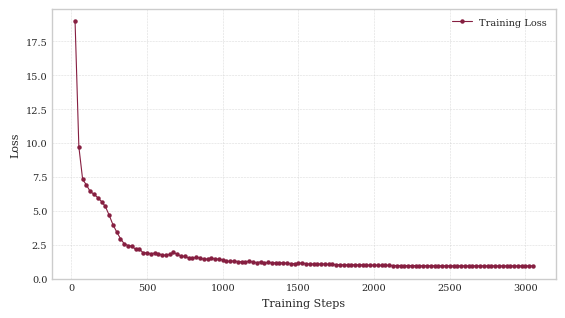

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:

path = "/content/drive/MyDrive/trocr_model_sunda_jawa_FINAL4/checkpoint-3060/trainer_state.json"

with open(path, "r") as f:
    data = json.load(f)

log_history = data["log_history"]

steps = [entry["step"] for entry in log_history if "loss" in entry]
losses = [entry["loss"] for entry in log_history if "loss" in entry]

plt.figure(figsize=(6.5, 3.5))
plt.style.use('seaborn-v0_8-whitegrid')

plt.rc('font', family='serif', size=8)
plt.rc('axes', titlesize=8, labelsize=8)
plt.rc('legend', fontsize=7)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)

plt.grid(True, linestyle="--", linewidth=0.4, alpha=0.7)

plt.plot(
    steps,
    losses,
    marker='o',
    markersize=2.2,
    color='#861F41',
    linewidth=0.8,
    label="Training Loss"
)

plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.ylim(bottom=0)

plt.legend(frameon=False)

file_name = "TrOCR_Training_Loss_IEEE.png"
plt.savefig(file_name, dpi=600, bbox_inches='tight')

plt.show()

files.download(file_name)


The next cell is to display and visualize the FPS and model accuracy comparison for literature review.

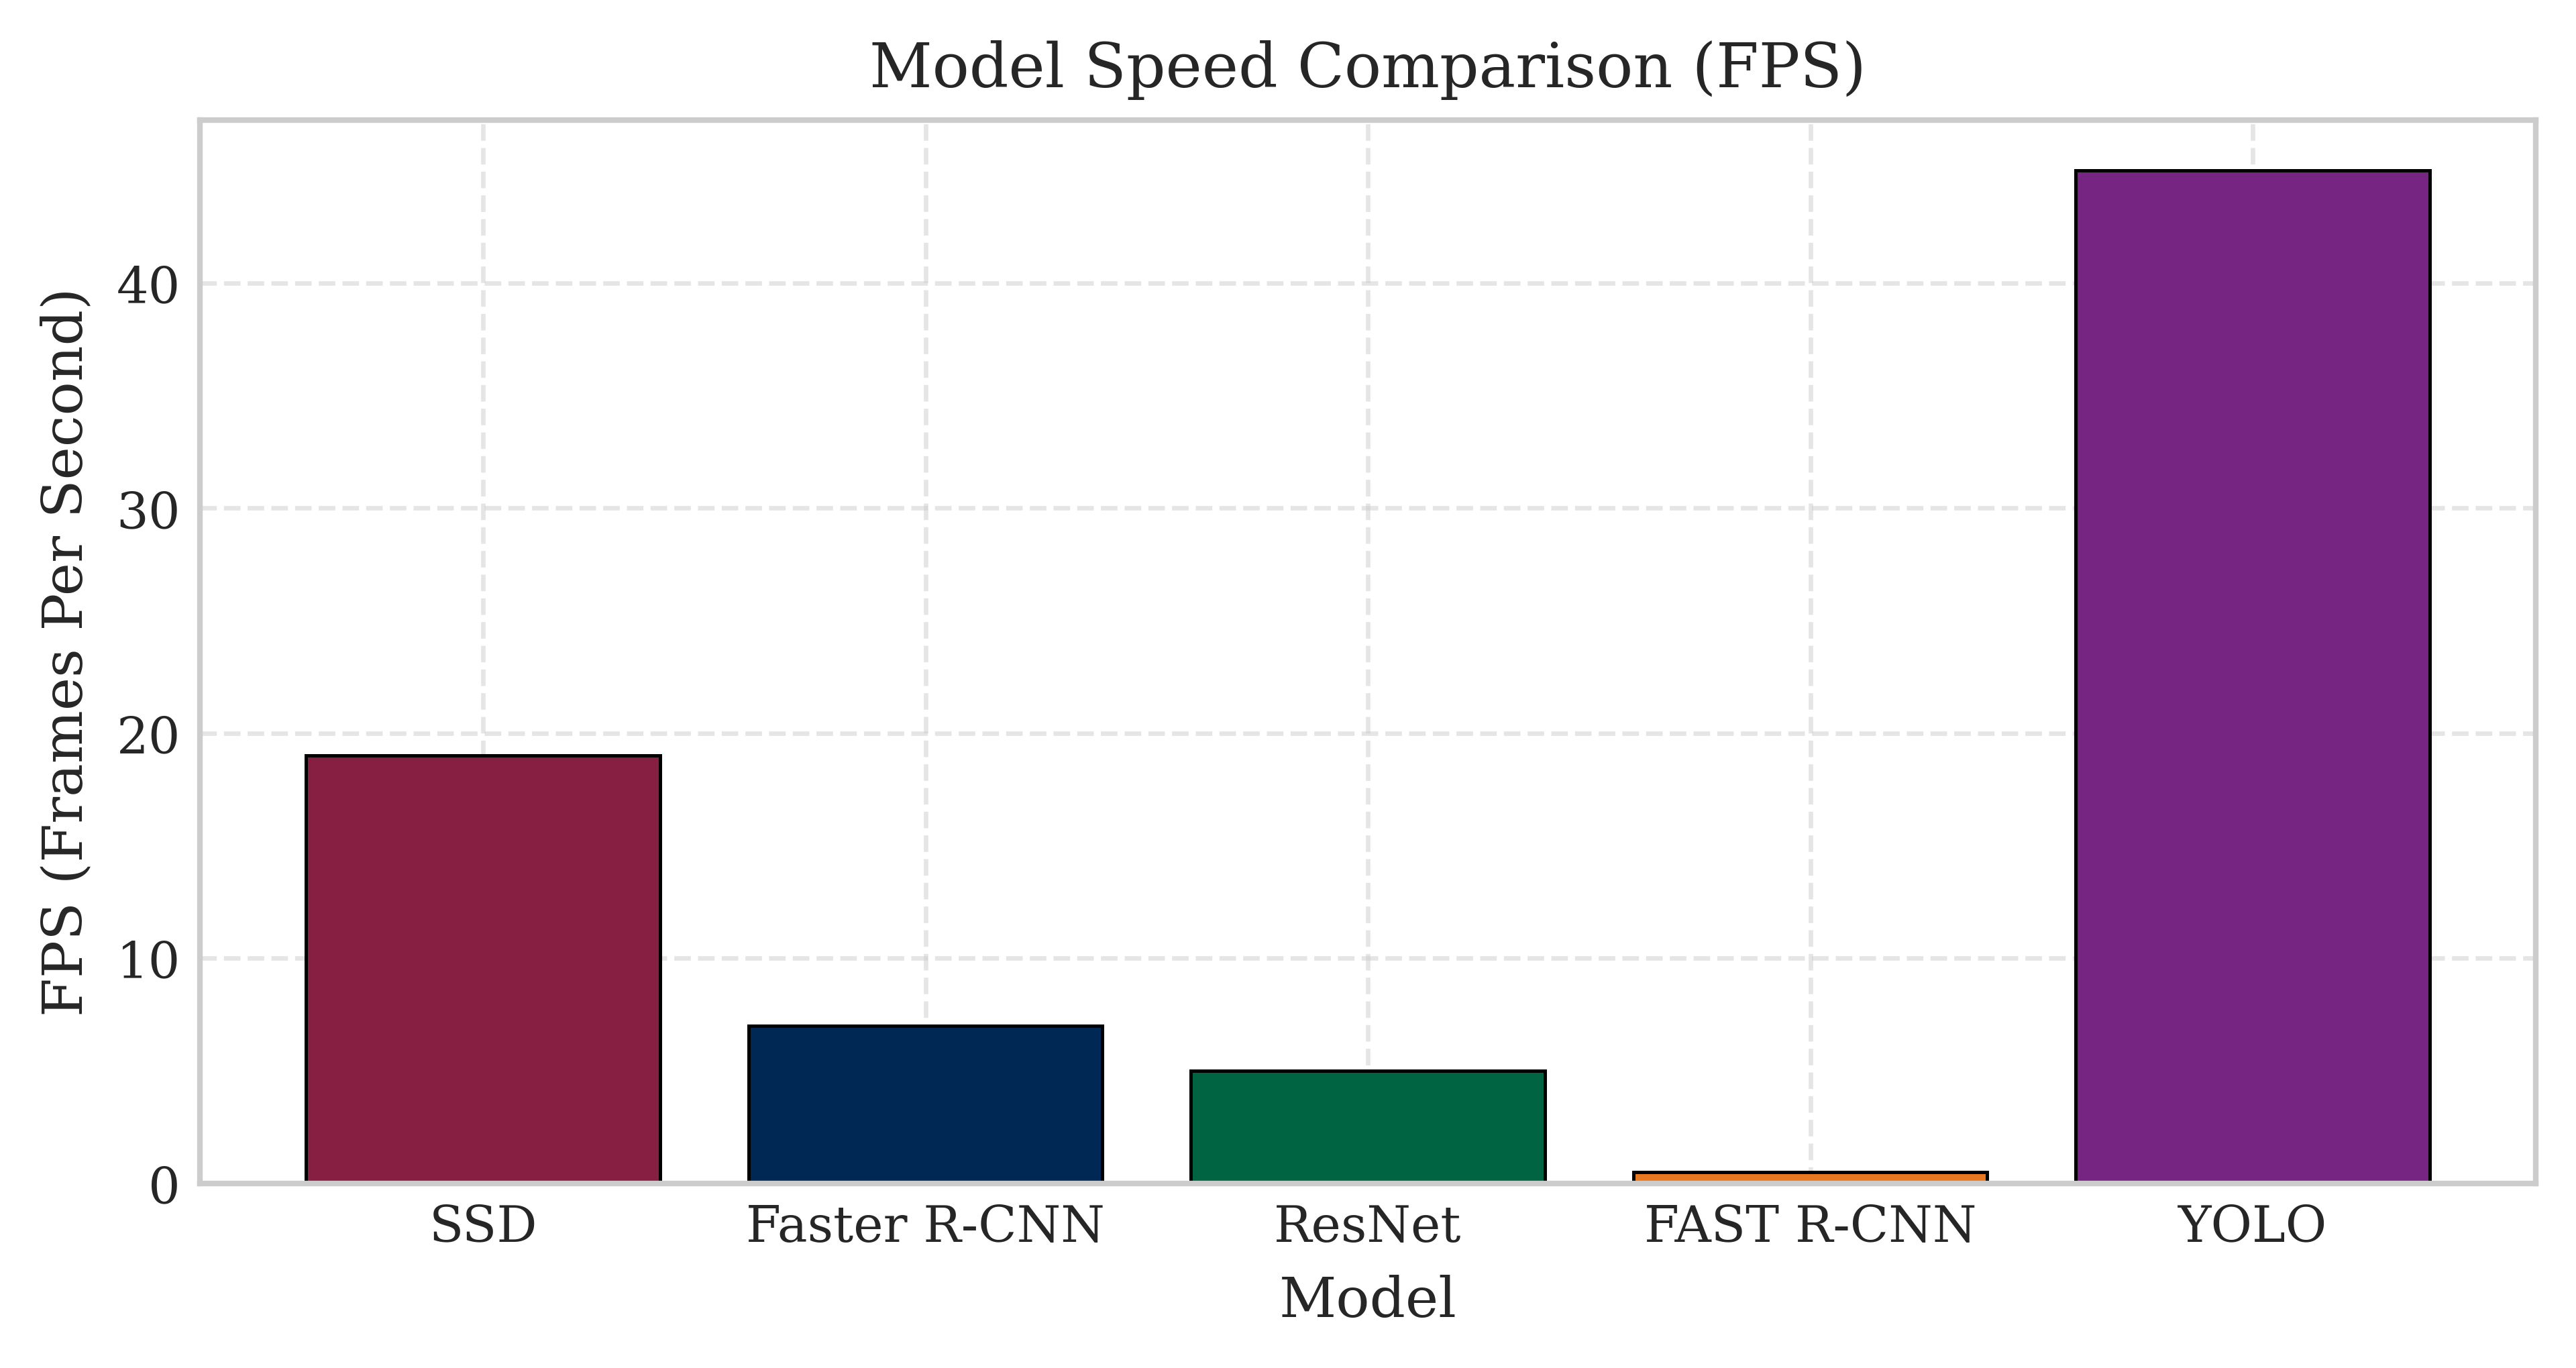

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

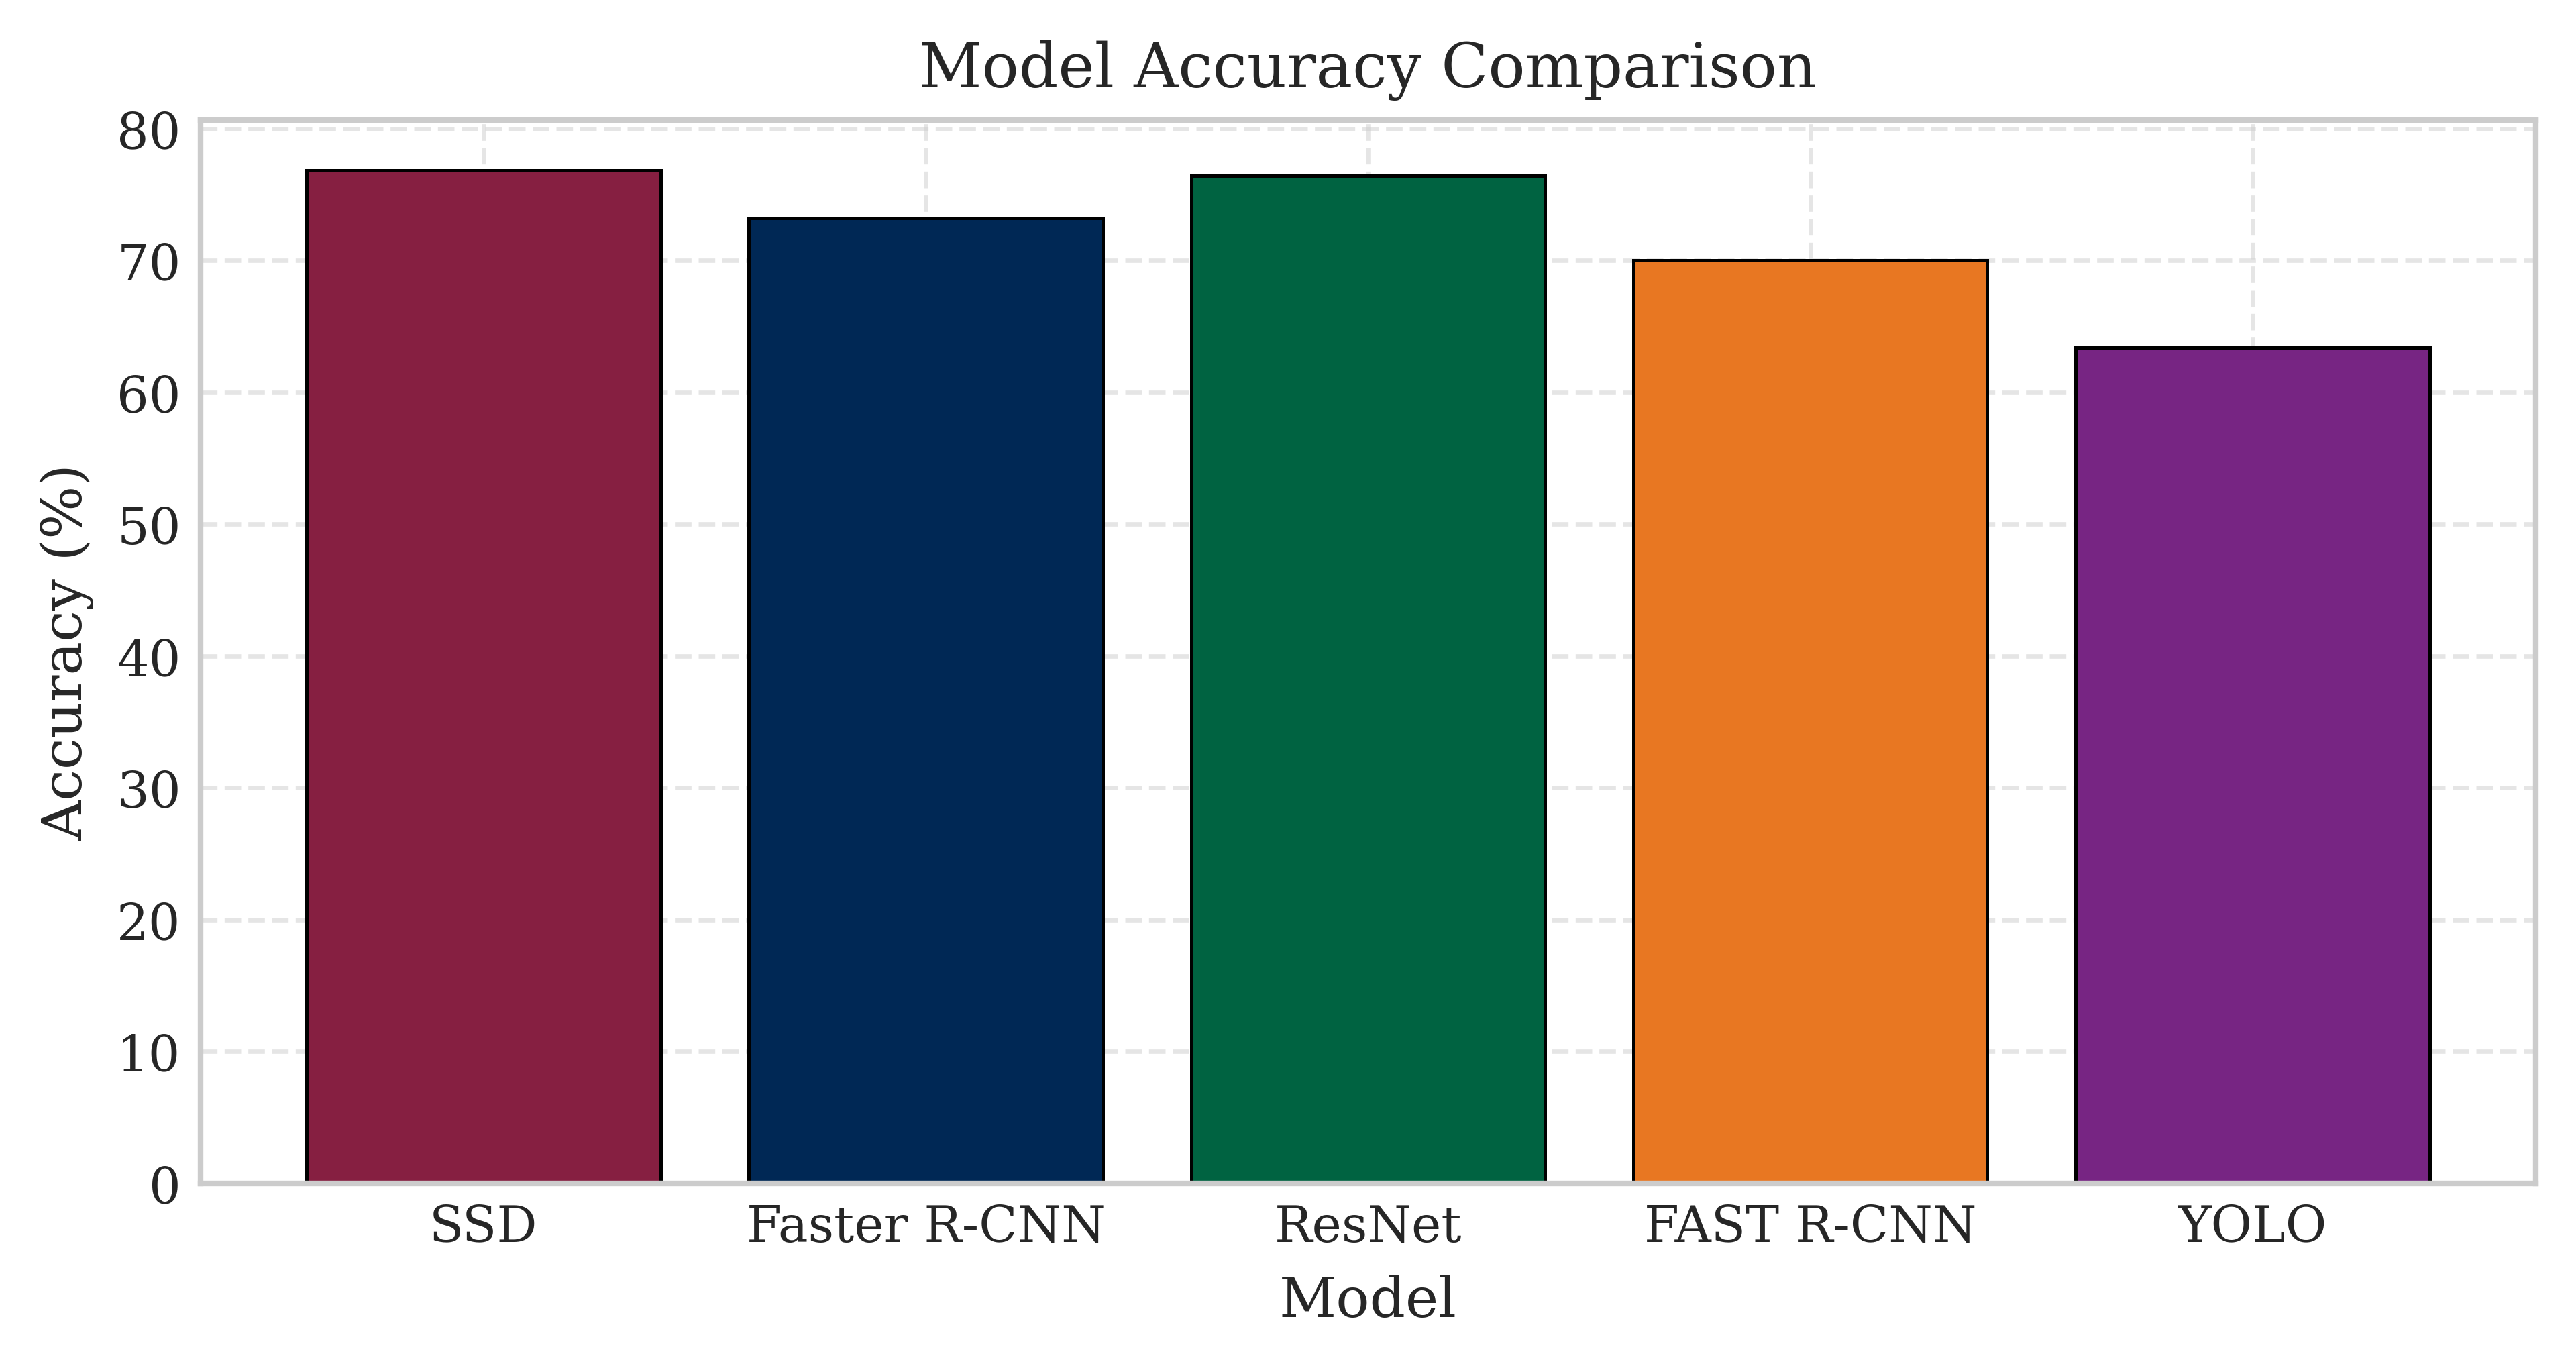

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:

models = ["SSD", "Faster R-CNN", "ResNet", "FAST R-CNN", "YOLO"]
fps_values = [19, 7, 5, 0.5, 45]
accuracy_values = [76.8, 73.2, 76.4, 70, 63.4]

plt.style.use('seaborn-v0_8-whitegrid')

plt.rc('font', family='serif', size=10)
plt.rc('axes', labelsize=10, titlesize=11)
plt.rc('legend', fontsize=9)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
plt.rc('lines', linewidth=1)

FIG_SIZE = (6.5, 3.5)

colors = [
    "#861F41",
    "#002855",
    "#006341",
    "#E87722",
    "#772583"
]


plt.figure(figsize=FIG_SIZE, dpi=600)

plt.bar(models, fps_values,
        color=colors, edgecolor="black", linewidth=0.6)

plt.ylabel("FPS (Frames Per Second)")
plt.xlabel("Model")
plt.title("Model Speed Comparison (FPS)")
plt.grid(True, linestyle="--", alpha=0.5)

fps_file = "IEEE_FPS_Comparison_COLORED.png"
plt.tight_layout()
plt.savefig(fps_file, dpi=600, bbox_inches='tight')
plt.show()
files.download(fps_file)

plt.figure(figsize=FIG_SIZE, dpi=600)

plt.bar(models, accuracy_values,
        color=colors, edgecolor="black", linewidth=0.6)

plt.ylabel("Accuracy (%)")
plt.xlabel("Model")
plt.title("Model Accuracy Comparison")
plt.grid(True, linestyle="--", alpha=0.5)

acc_file = "IEEE_Accuracy_Comparison_COLORED.png"
plt.tight_layout()
plt.savefig(acc_file, dpi=600, bbox_inches='tight')
plt.show()
files.download(acc_file)
